In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
from itertools import chain

# Setting up the visual aesthetics for professional plots
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12, 'figure.figsize': (12, 6)})

print("Environment ready: Data stack loaded.")

Environment ready: Data stack loaded.


In [2]:
# Use absolute paths to avoid Windows directory confusion
base_dir = pathlib.Path('../data').resolve()

# Recursively find all .png files and map 'filename' -> 'full_path'
# This dictionary approach is much faster than searching during training
image_map = {path.name: str(path) for path in base_dir.glob('**/*.png')}

print(f"Total images located on disk: {len(image_map)}")
if len(image_map) < 112120:
    print("Note: Some images might be missing based on the full NIH dataset count.")

Total images located on disk: 112120


In [3]:
# Load the master CSV file
csv_path = base_dir / 'Data_Entry_2017.csv'
df = pd.read_csv(csv_path)

# Map the 'Image Index' column to the actual physical path on your drive
df['path'] = df['Image Index'].map(image_map.get)

# Drop records that don't have a corresponding image file downloaded
initial_count = len(df)
df = df.dropna(subset=['path']).copy()
print(f"Data linked. Kept {len(df)} out of {initial_count} records.")

# Quick look at the structure
df.head()

Data linked. Kept 112120 out of 112120 records.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,E:\pro\Data\images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,E:\pro\Data\images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,E:\pro\Data\images_001\images\00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,E:\pro\Data\images_001\images\00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,E:\pro\Data\images_001\images\00000003_000.png


In [4]:
# Extract all unique pathology labels
# 1. Split strings by '|', 2. Flatten the list, 3. Find unique values
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0 and x != 'No Finding']

# Create a binary column for each pathology (0 or 1)
for label in all_labels:
    df[label] = df['Finding Labels'].map(lambda x: 1.0 if label in x else 0.0)

print(f"Disease Labels identified ({len(all_labels)}): \n{all_labels}")

Disease Labels identified (14): 
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Full list of pathology counts (from most frequent to least):
----------------------------------------
Infiltration          19894.0
Effusion              13317.0
Atelectasis           11559.0
Nodule                 6331.0
Mass                   5782.0
Pneumothorax           5302.0
Consolidation          4667.0
Pleural_Thickening     3385.0
Cardiomegaly           2776.0
Emphysema              2516.0
Edema                  2303.0
Fibrosis               1686.0
Pneumonia              1431.0
Hernia                  227.0
dtype: float64
----------------------------------------


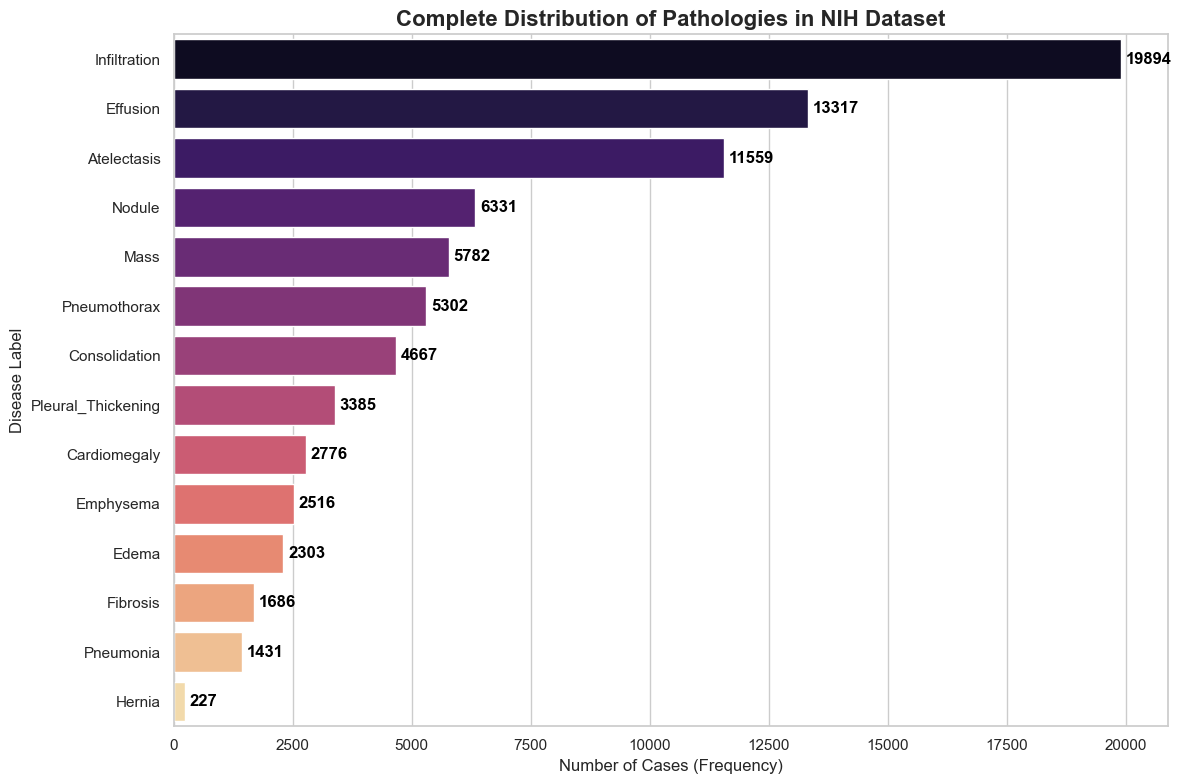

In [5]:
# Calculate the total count for each pathology label
# We sum the binary columns for all 14 diseases
full_label_counts = df[all_labels].sum().sort_values(ascending=False)

# Display the exact numbers for all pathologies
print("Full list of pathology counts (from most frequent to least):")
print("-" * 40)
print(full_label_counts)
print("-" * 40)

# Visualization of the entire distribution
plt.figure(figsize=(12, 8))
# Using a color palette to distinguish different diseases
sns.barplot(x=full_label_counts.values, 
            y=full_label_counts.index, 
            hue=full_label_counts.index, 
            palette='magma', 
            legend=False)

plt.title('Complete Distribution of Pathologies in NIH Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Number of Cases (Frequency)', fontsize=12)
plt.ylabel('Disease Label', fontsize=12)

# Add the exact count at the end of each bar for professional reporting
for i, v in enumerate(full_label_counts.values):
    plt.text(v + 100, i, str(int(v)), color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Max age found: 414


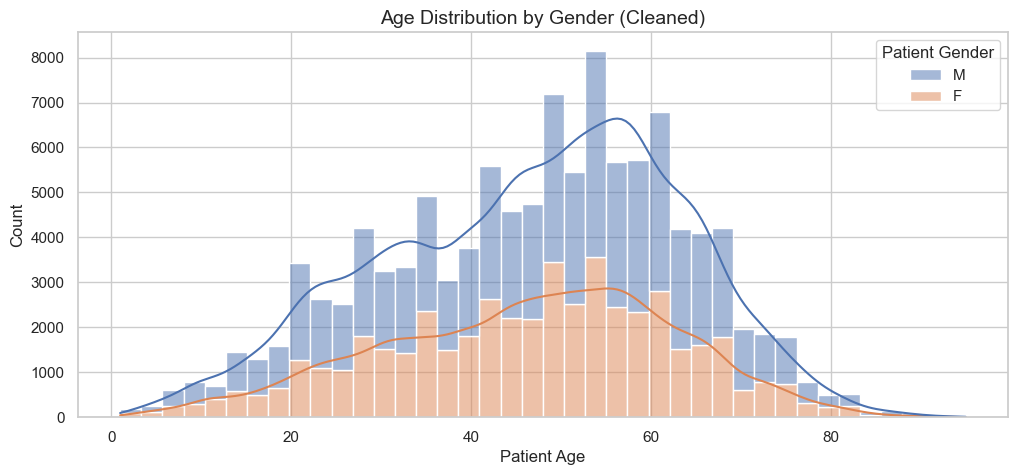

In [6]:
# Check for unrealistic age values
print(f"Max age found: {df['Patient Age'].max()}")

# Filter out unrealistic data (keeping ages between 0 and 100)
df = df[df['Patient Age'] <= 100]

# Visualize Age Distribution by Gender
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='Patient Age', hue='Patient Gender', multiple="stack", bins=40, kde=True)
plt.title('Age Distribution by Gender (Cleaned)', fontsize=14)
plt.show()

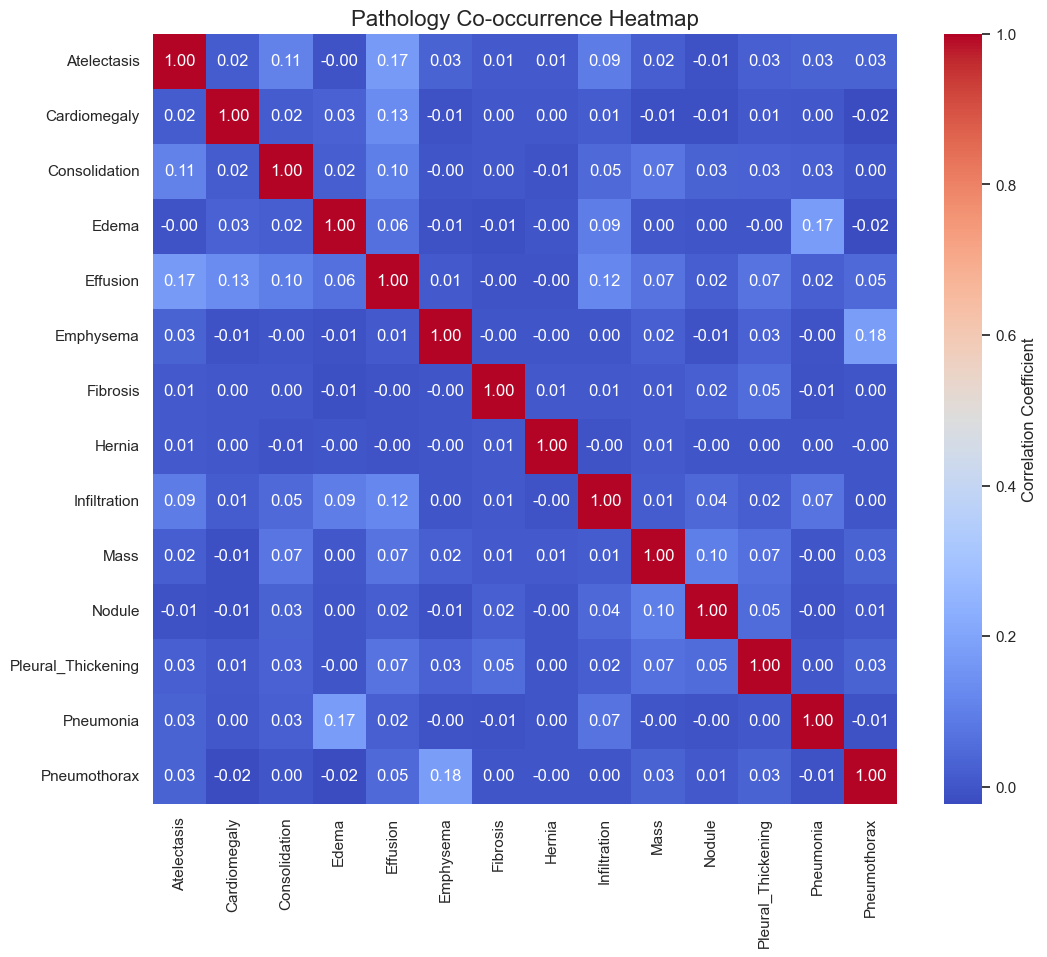

In [7]:
# Calculate correlation matrix for pathologies
plt.figure(figsize=(12, 10))
sns.heatmap(df[all_labels].corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Pathology Co-occurrence Heatmap', fontsize=16)
plt.show()

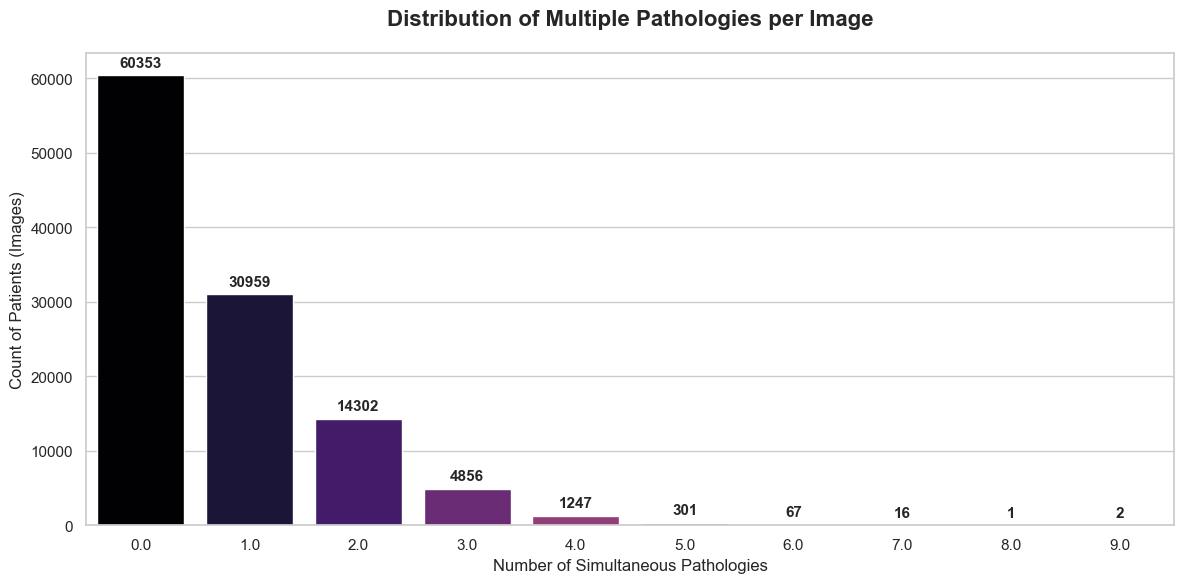

Percentage of patients with multiple diseases:
disease_count
0.0    53.836616
1.0    27.616321
2.0    12.757796
3.0     4.331692
4.0     1.112360
5.0     0.268501
6.0     0.059766
7.0     0.014272
8.0     0.000892
9.0     0.001784
Name: proportion, dtype: float64


In [8]:
# Calculate the number of diseases for each patient
# We sum the binary columns we created earlier (all_labels)
df['disease_count'] = df[all_labels].sum(axis=1)

# Set up the visualization
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='disease_count', palette='magma', hue='disease_count', legend=False)

# Professional Formatting
plt.title('Distribution of Multiple Pathologies per Image', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Simultaneous Pathologies', fontsize=12)
plt.ylabel('Count of Patients (Images)', fontsize=12)

# Add value labels on top of each bar for better readability
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Print the exact percentage for the report
counts = df['disease_count'].value_counts(normalize=True) * 100
print("Percentage of patients with multiple diseases:")
print(counts.sort_index())

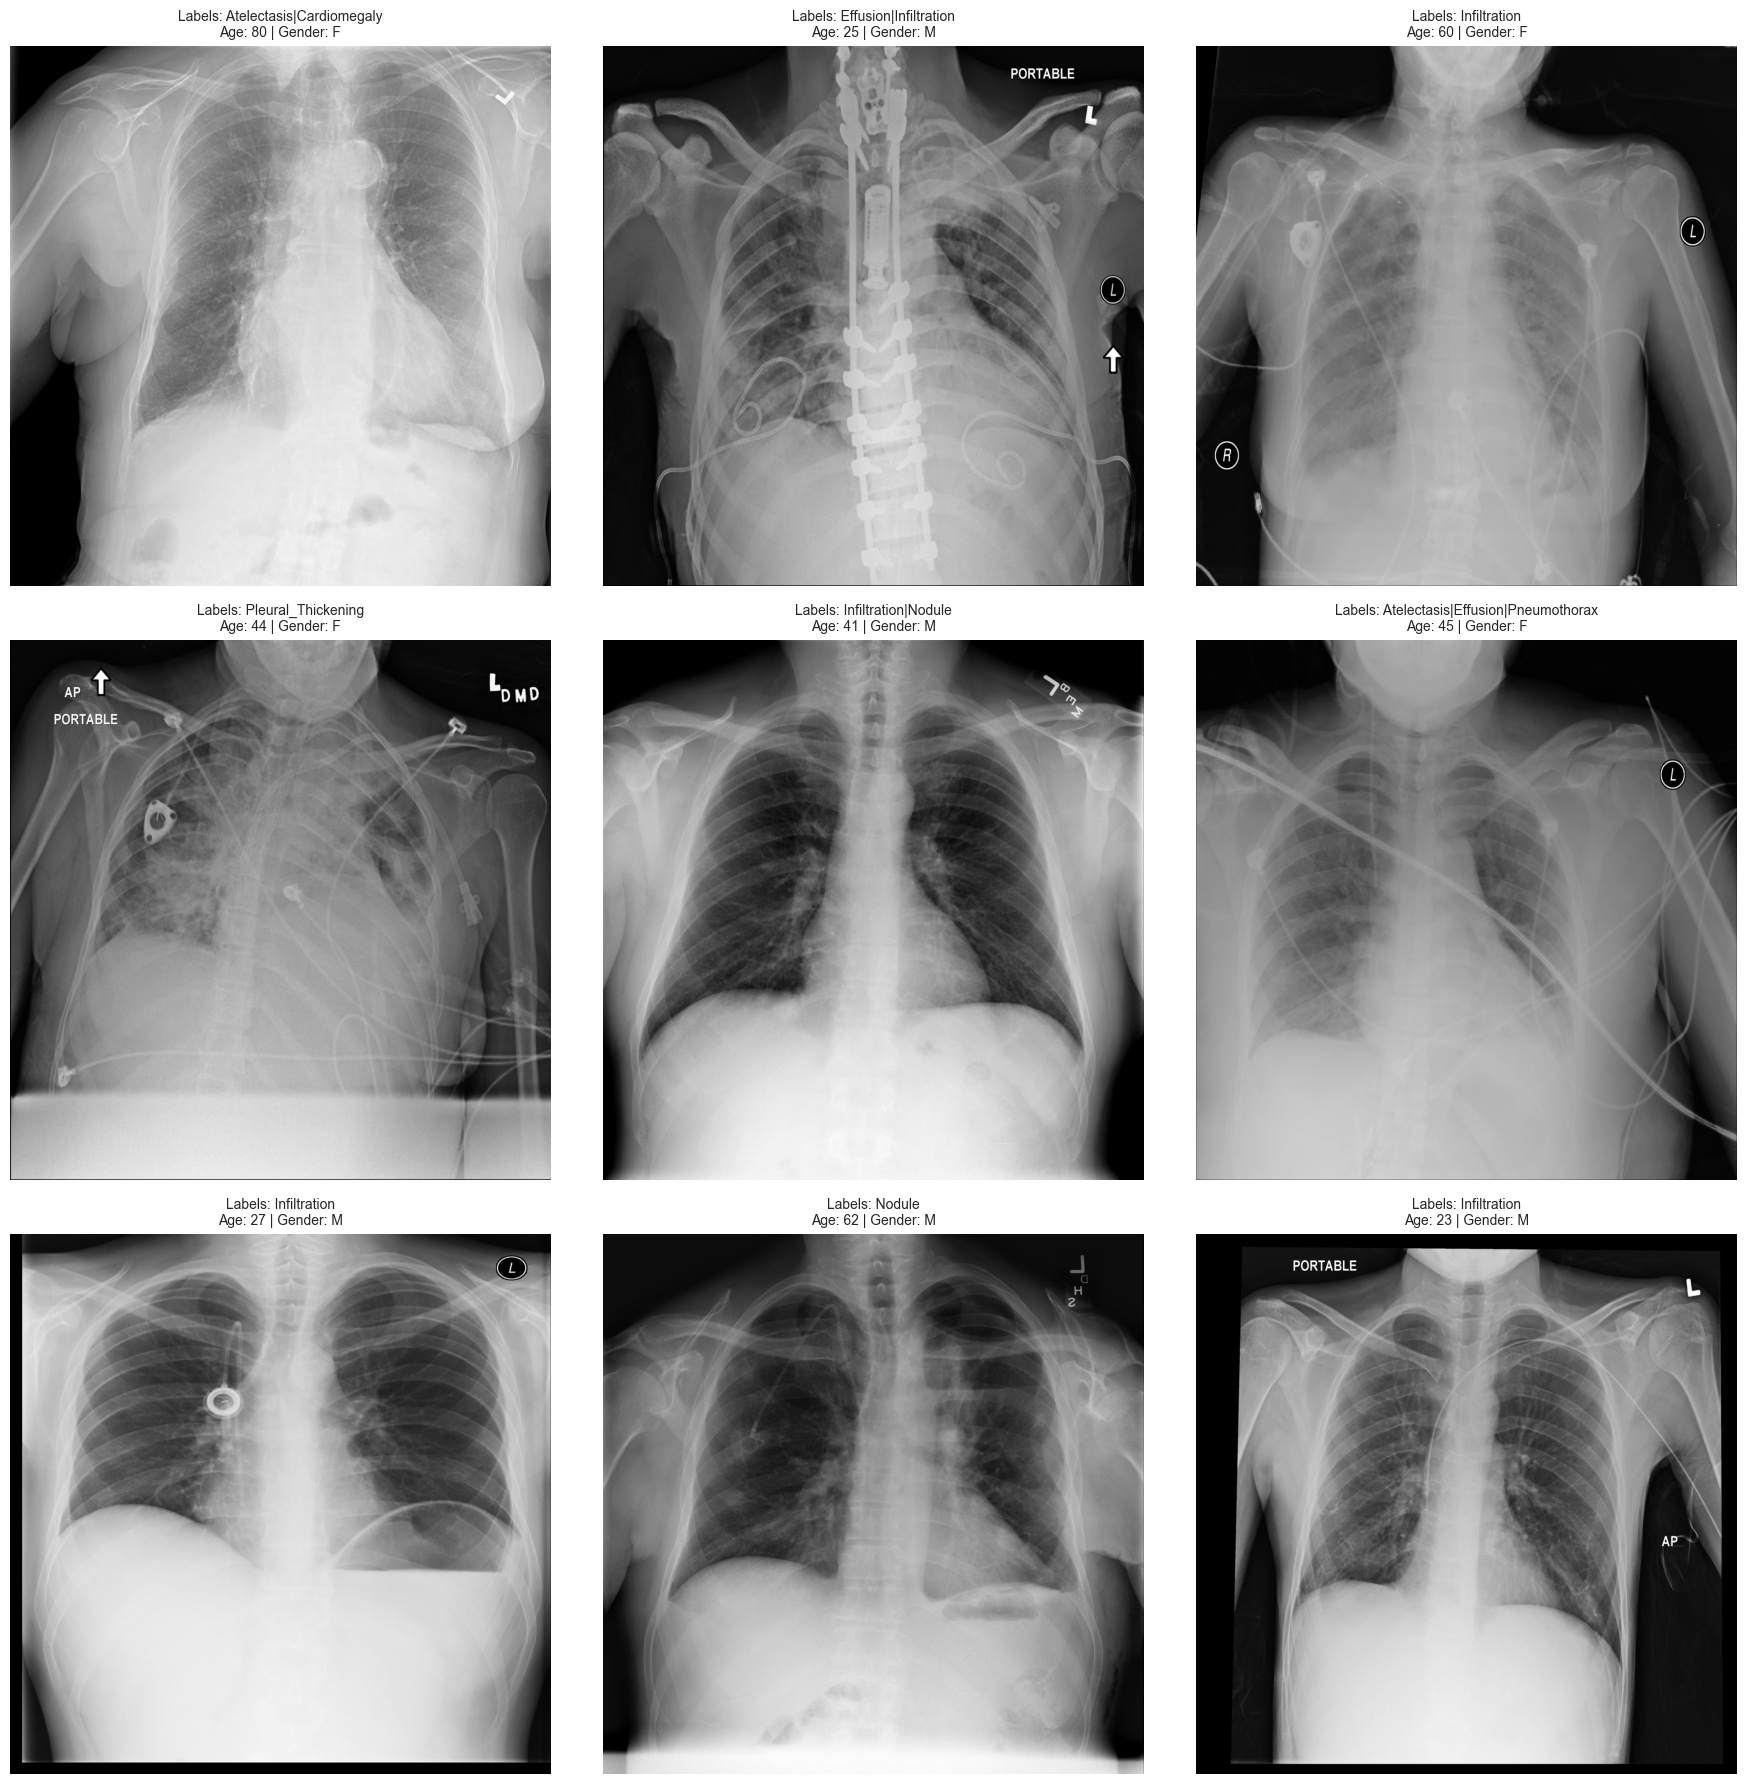

In [9]:
# Sampling 9 random images with at least one pathology
sample_data = df[df['Finding Labels'] != 'No Finding'].sample(9)

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
for i, (idx, row) in enumerate(sample_data.iterrows()):
    ax = axes[i//3, i%3]
    img = plt.imread(row['path'])
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Labels: {row['Finding Labels']}\nAge: {row['Patient Age']} | Gender: {row['Patient Gender']}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Save the processed dataframe
output_path = base_dir / 'cleaned_data.csv'
df.to_csv(output_path, index=False)

print(f"EDA Complete! Cleaned dataset saved to: {output_path}")
print(f"Final dataset size: {df.shape}")

EDA Complete! Cleaned dataset saved to: E:\pro\Data\cleaned_data.csv
Final dataset size: (112104, 28)
